# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot
import seaborn as sns

import numpy

from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

In [226]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



id = '1VDFn9tpwO0ecnr5DiC7TQwg-GVoPJUEK'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('database.sqlite')  

# df2 = pd.read_csv(io.BytesIO(uploaded['Filename.csv']))

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 15000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (15000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [228]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [229]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [230]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [231]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [233]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(14470, 10)

In [234]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.46666666666667

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [235]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [237]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(14470, 10)


1    12187
0     2283
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [238]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_50 = final['Text'].values[50]
print(sent_50)
print("="*50)

sent_150 = final['Text'].values[150]
print(sent_150)
print("="*50)

sent_490 = final['Text'].values[490]
print(sent_490)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I haven't tried a bad seasoning flavor yet.  These are wonderful.  My favorites are Vegetable Magic (not just for vegetables....makes delicious omelettes) and Pork Magic (saute centercut pork chops in olive oil and sprinkle with the Pork Magic).  My kids LOVE it.
I was disappointed by these eucalyptus leaves - they have a stale, oregano-like smell. Ask your local florist to get you some fresh leaves!
My dogs LOVE these treats! Freeze dried easy to throw some in a zip lock bag and take them with you. Wonderful training treats because they're so easy to put in your pocket. Great deal too!


In [239]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_50 = re.sub(r"http\S+", "", sent_50)
sent_150 = re.sub(r"http\S+", "", sent_150)
sent_490 = re.sub(r"http\S+", "", sent_490)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [240]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_150, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_490, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I haven't tried a bad seasoning flavor yet.  These are wonderful.  My favorites are Vegetable Magic (not just for vegetables....makes delicious omelettes) and Pork Magic (saute centercut pork chops in olive oil and sprinkle with the Pork Magic).  My kids LOVE it.
I was disappointed by these eucalyptus leaves - they have a stale, oregano-like smell. Ask your local florist to get you some fresh leaves!
My dogs LOVE these treats! Freeze dried easy to throw some in a zip lock bag and take them with you. Wonderful training treats because they're so easy to put in your pocket. Great deal too!


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [242]:
sent_150 = decontracted(sent_150)
print(sent_150)
print("="*50)

I was disappointed by these eucalyptus leaves - they have a stale, oregano-like smell. Ask your local florist to get you some fresh leaves!


In [243]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [244]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_150 = re.sub('[^A-Za-z0-9]+', ' ', sent_150)
print(sent_150)

I was disappointed by these eucalyptus leaves they have a stale oregano like smell Ask your local florist to get you some fresh leaves 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [247]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[18]

100%|██████████| 14470/14470 [00:06<00:00, 2275.17it/s]


'according cat stuff great licks hours eating one loves taste lick bowl clean one eats usually pretty quickly still not want times month fish not exactly favorite food great diversion regular fare one truly appreciates'

## [3.2] Preprocessing Review Summary

In [248]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[18]

100%|██████████| 14470/14470 [00:04<00:00, 3168.17it/s]


'great food cats'

# [4] Featurization

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [250]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.8399016261100769), ('good', 0.8370885252952576), ('wonderful', 0.7873727083206177), ('fantastic', 0.7621129155158997), ('amazing', 0.7313238978385925), ('awesome', 0.7250334620475769), ('decent', 0.7133233547210693), ('super', 0.7074976563453674), ('well', 0.6800954937934875), ('quick', 0.6793903708457947)]
[('disappointing', 0.9362329840660095), ('colombia', 0.9274441599845886), ('hooked', 0.9161827564239502), ('possibly', 0.9158511161804199), ('compleats', 0.9130663871765137), ('allot', 0.9116002321243286), ('exciting', 0.9111012816429138), ('hottest', 0.9064038991928101), ('hands', 0.9063706398010254), ('newer', 0.9049025774002075)]


In [251]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7126
sample words  ['product', 'available', 'traps', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [252]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 14470/14470 [00:25<00:00, 562.38it/s]

14470
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [254]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 14470/14470 [03:18<00:00, 72.97it/s]


In [0]:
def plotWordCloud(text):

  #  https://www.geeksforgeeks.org/generating-word-cloud-python/

  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  min_font_size = 10).generate(text) 

  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  plt.show()
  
# fetch result from dataframe, where matchlabel== expected label, finally convert to string
def returnWordCloudString(df, matchlabel):
   return df['Text'][df.label == matchlabel].to_string()
  



## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V

In [256]:
X_data = StandardScaler().fit_transform(sent_vectors)

print(X_data.shape)
# using SVD we can reduce dimension
svd = TruncatedSVD(n_components=30)
X_data = svd.fit_transform(X_data)

# ideally min_points should be 2*dimension
min_pts = 2*X_data.shape[1] 

print(min_pts)

(14470, 50)
60


In [257]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors
# https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan

neigh = NearestNeighbors(n_neighbors=min_pts, metric = "euclidean")
neigh.fit(X_data)

distances, indices =neigh.kneighbors(n_neighbors=min_pts, return_distance= 'True')
print('Varible Type: distance : ',type(distances), ' indices ', type(indices))
print('--'*50)
print(distances)
print('--'*50)
print(indices)

Varible Type: distance :  <class 'numpy.ndarray'>  indices  <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------
[[2.1982337  2.27082473 2.28303419 ... 3.38953709 3.389678   3.39035115]
 [3.27621398 3.36319619 3.46282561 ... 4.48432631 4.48973241 4.50771064]
 [2.41715736 2.54514938 2.65632881 ... 3.26561203 3.26791769 3.26861843]
 ...
 [1.78462503 1.8622877  1.90526809 ... 2.99395713 2.99737945 2.99960007]
 [2.18101749 2.50736553 2.59412174 ... 3.3482714  3.36865096 3.36899623]
 [3.94118453 4.28970801 4.30079456 ... 5.13645327 5.1386851  5.1405664 ]]
----------------------------------------------------------------------------------------------------
[[ 8600 14304  3905 ...  8246 13001  8512]
 [12599  5491  5173 ...  9303 12563  6547]
 [ 1156  4161 11990 ...  6133  3356  3689]
 ...
 [11236   704 10997 ...  9203  6140   905]
 [ 4920  4905  7871 ...  6930 11965  8579]
 [10237  8801 12482 ...   472  1000 13112]]


In [258]:
distances.shape, indices.shape

((14470, 60), (14470, 60))

(14470,)


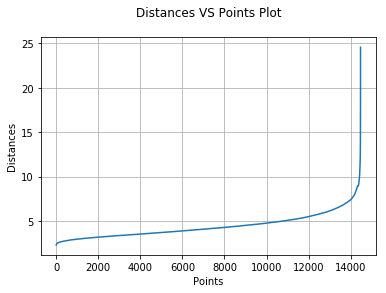

In [259]:
# taking last coloumn of above matrices

lst_=[]
for last_col in distances:
  lst_.append(last_col[-1]) 
lst_ = np.array(lst_)
print(lst_.shape)

# sort the matrices
lst_ = np.sort(lst_)

# take points
points = [i for i in range(X_data.shape[0])]
len(points)

# plot points vs distance

plt.plot(points, lst_)
plt.xlabel('Points')
plt.ylabel('Distances')
plt.title('Distances VS Points Plot\n')
plt.grid()
plt.show()

In [0]:
clustering = DBSCAN(eps=9.0, min_samples=min_pts).fit(X_data)
labels = clustering.labels_

In [261]:
no_of_clusters = set(labels.flatten())
no_of_clusters

{-1, 0}

In [0]:
# create duplicate copy of original dataframe as final2
final2 = final.copy()

# adding this labels result to duplicate copy dataframe
final2['label']= labels

# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final2,0)

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V

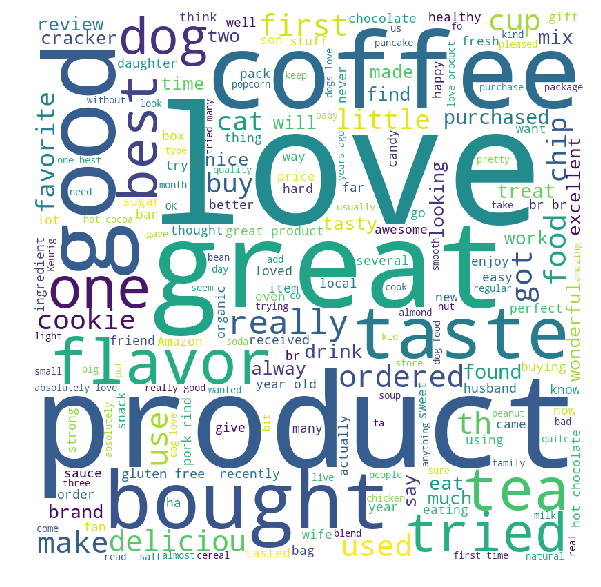

In [263]:
plotWordCloud(cluster_0)

# Observation

We have find EPS value using Knee method, which is near about 9. Min_pts value typically , 2* dimensions ie 60.

As a domain knowledge we know that there are two type of cluster, Review 'Positive' or 'Negative' so there should two cluster, but our model identified only one cluster so our model is not performing good enough.

### [5.3.3] Applying DBSCAN on TFIDF W2V

In [264]:
X_data = StandardScaler().fit_transform(tfidf_sent_vectors)

print(X_data.shape)
# using SVD we can reduce dimension
svd = TruncatedSVD(n_components=30)
X_data = svd.fit_transform(X_data)

# ideally min_points should be 2*dimension
min_pts = 2*X_data.shape[1] 

print(min_pts)

(14470, 50)
60


Apply Knearest algorithm to find distance of each points from other point depend on k nearest neighbour, using euclidean distance.

In [265]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors
# https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan

neigh = NearestNeighbors(n_neighbors=min_pts, metric = "euclidean")
neigh.fit(X_data)

distances, indices =neigh.kneighbors(n_neighbors=min_pts, return_distance= 'True')
print('Varible Type: distance : ',type(distances), ' indices ', type(indices))
print('--'*50)
print(distances)
print('--'*50)
print(indices)



Varible Type: distance :  <class 'numpy.ndarray'>  indices  <class 'numpy.ndarray'>
----------------------------------------------------------------------------------------------------
[[1.48478857 1.56472034 1.72636535 ... 2.44862123 2.45164107 2.4540929 ]
 [1.79126422 1.88737522 2.16325639 ... 3.10661326 3.10767773 3.10859054]
 [1.74111362 1.74271045 1.7584274  ... 2.20031471 2.20144285 2.2048267 ]
 ...
 [1.41570807 1.73833134 1.74588969 ... 2.71141044 2.73093227 2.74370299]
 [2.17709703 2.30003983 2.33079637 ... 3.09586687 3.10358737 3.10418458]
 [2.89305196 3.11853224 3.12164375 ... 3.83088433 3.83375893 3.83780464]]
----------------------------------------------------------------------------------------------------
[[ 3905 14304  6533 ... 14398 14292 12302]
 [12940  5173   984 ...  2187 12614    39]
 [ 8197  9765 13888 ...  8393  4238   501]
 ...
 [ 9093 12241   902 ...  8636 11102 10734]
 [ 4920  3630  8756 ... 10574 13094  7835]
 [10237  6604 12482 ...  8857   995  7990]]


In [266]:
distances.shape, indices.shape

((14470, 60), (14470, 60))

(14470,)


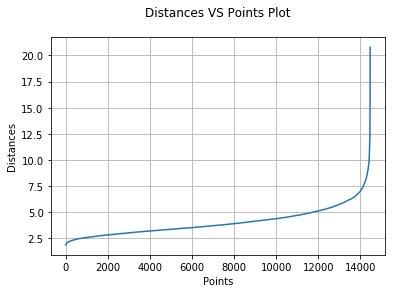

In [267]:
# taking last coloumn of above matrices

lst_=[]
for last_col in distances:
  lst_.append(last_col[-1]) 
lst_ = np.array(lst_)
print(lst_.shape)

# sort the matrices
lst_ = np.sort(lst_)

# take points
points = [i for i in range(X_data.shape[0])]
len(points)

# plot points vs distance

plt.plot(points, lst_)
plt.xlabel('Points')
plt.ylabel('Distances')
plt.title('Distances VS Points Plot\n')
plt.grid()
plt.show()

In [268]:
arr = np.array([100.10, 200.42, 4.14, 89.00, 34.55, 1.12])
arr[[0,3,5]]

array([100.1 ,  89.  ,   1.12])

In [0]:
clustering = DBSCAN(eps=8.0, min_samples=min_pts).fit(X_data)
labels = clustering.labels_

In [275]:
no_of_clusters = set(labels.flatten())
no_of_clusters

{-1, 0}

In [0]:
# create duplicate copy of original dataframe as final2
final2 = final.copy()

# adding this labels result to duplicate copy dataframe
final2['label']= labels

# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final2,0)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

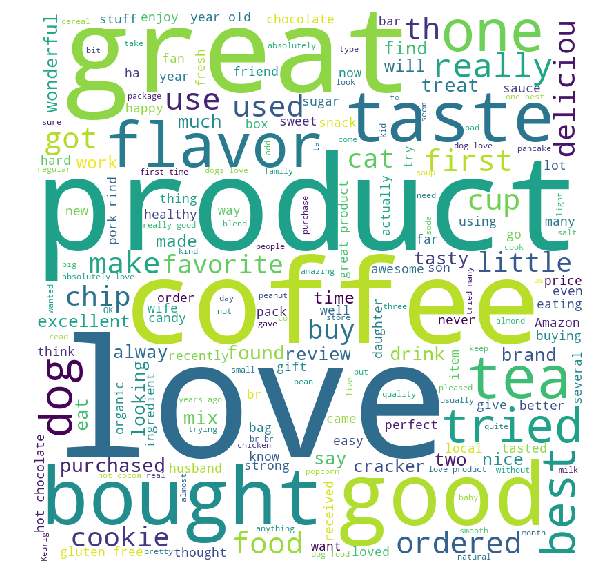

In [277]:
plotWordCloud(cluster_0)

#Observation

We have find EPS value using Knee method, which is near about 8. Min_pts value typically , 2* dimensions ie 60.

As a domain knowledge we know that there are two type of cluster, Review 'Positive' or 'Negative' so there should two cluster, but our model identified only one cluster so our *model is not performing good enough*.

# [6] Conclusions

 For all experiement we have consider **15000** datapoints.

In [273]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Models", "AvgW2V (Top words)", "TFIDF-W-W2V (Top words)"]

x.add_row(["epsilon  ","10.0", "10.0" ])
x.add_row(["min_pts ","60", "60" ])
x.add_row(["No. of clusters=6 : "," love,product,great,coffee", "great,love,coffee,favour,bought" ])


print(x)

+----------------------+----------------------------+---------------------------------+
|        Models        |     AvgW2V (Top words)     |     TFIDF-W-W2V (Top words)     |
+----------------------+----------------------------+---------------------------------+
|      epsilon         |            10.0            |               10.0              |
|       min_pts        |             60             |                60               |
| No. of clusters=6 :  |  love,product,great,coffee | great,love,coffee,favour,bought |
+----------------------+----------------------------+---------------------------------+


## Observation

All words are mixed into single cluster it is not performing better, note we have conclude only by observing word cloud.